In [12]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from helper_functions import set_seeds


import os
import numpy as np
import random
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset, SequentialSampler, BatchSampler
from torchvision import datasets, transforms

from going_modular.going_modular import engine


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
torch.set_num_threads(8)

In [15]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['Cerscospora', 'Healthy', 'Leaf_rust', 'Miner', 'Phoma']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit

In [16]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       )

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VisionTransformer                             [32, 3, 224, 224]    [32, 5]              768                  Partial
├─Conv2d: 1-1                                 [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder: 1-2                                [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout: 2-1                           [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential: 2-2                        [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock: 3-3                 [32, 197, 768]       [32, 197, 

In [17]:
train_dir = "dataset224/train_data"
test_dir = "dataset224/test_data"
# train_dir = "small_dataset2"
# test_dir = "small_dataset2"

In [18]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [19]:

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS,
    sample_size: int=-1
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # If sample_size is not specified or is -1, use the full dataset
  if sample_size == -1:
      train_dataloader = DataLoader(
          train_data,
          batch_size=batch_size,
          shuffle=True,
          num_workers=num_workers,
          pin_memory=True,
      )
  else:
      train_paths = train_data.samples
    
      # Randomly select a subset of the training data
      random.seed(42)  # for reproducibility
      selected_paths = random.sample(train_paths, k=sample_size)
    
      # Create a new dataset from the selected paths
      train_sampler = SubsetRandomSampler(selected_paths)
      train_dataloader = DataLoader(
          train_sampler,
          batch_size=batch_size,
          sampler=train_sampler,
          num_workers=num_workers,
          pin_memory=True,
      )

  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


In [20]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=128,
    sample_size=-1
) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [21]:
train_dataloader_pretrained.dataset

Dataset ImageFolder
    Number of datapoints: 40987
    Root location: dataset224/train_data
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [22]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=train_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1220 | train_acc: 0.9728 | test_loss: 0.0194 | test_acc: 0.9996
Epoch: 2 | train_loss: 0.0120 | train_acc: 0.9998 | test_loss: 0.0073 | test_acc: 0.9999
Epoch: 3 | train_loss: 0.0055 | train_acc: 0.9999 | test_loss: 0.0040 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0032 | train_acc: 1.0000 | test_loss: 0.0025 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0021 | train_acc: 1.0000 | test_loss: 0.0017 | test_acc: 1.0000


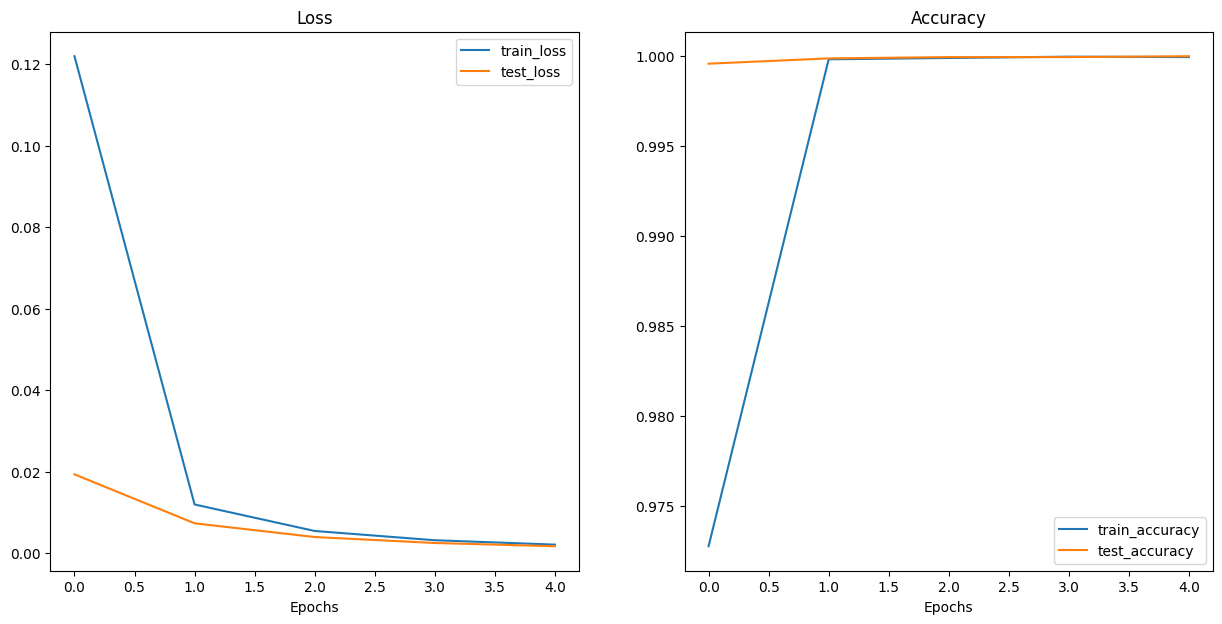

In [23]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

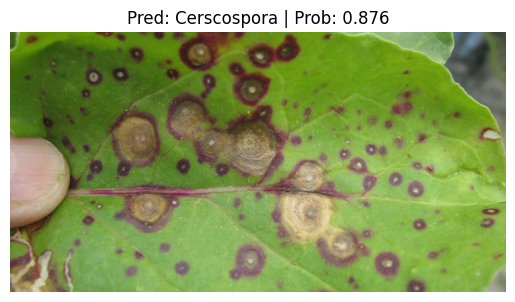

In [37]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = ""

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)